In [1]:
from market_env.constants import (
    coll_token, debt_token, initial_coll_price, initial_debt_price,
    closing_factor, liquidation_bonus, liquidation_threshold, 
    time_steps, number_of_users, mu, sigma, participation_proportion, total_collateral_usd
)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from __future__ import annotations

In [2]:
# Simulate price series for both collateral and debt token
# TODO: Replace with more advanced price simulation model
def simulate_prices(time_steps: int, initial_price: float, percent_price_change: float) -> list[float]:
    simulated_prices = [initial_price]
    percent_price_change = percent_price_change/100
    for _ in range(1, time_steps):
        # randomly decide whether to add or subtract the price change
        sign = +1 if random.random() < 0.5 else -1
        new_price = simulated_prices[-1] * (1 + sign * percent_price_change)
        simulated_prices.append(new_price)
    return simulated_prices

coll_prices = simulate_prices(time_steps, initial_coll_price, percent_price_change=1)
debt_prices = simulate_prices(time_steps, initial_debt_price, percent_price_change=0.01)

In [3]:
class User:
    def __init__(
        self, 
        user_id: int, 
        coll_usd: float, 
        debt_usd: float, 
        coll_price: float, 
        debt_price: float
    ):
        self.id = user_id
        
        # Positions in tokens
        self.supplied_tokens = coll_usd / coll_price
        self.borrowed_tokens = debt_usd / debt_price

        # Positions in USD
        self.supplied_usd = coll_usd
        self.borrowed_usd = debt_usd

        # Current LTV
        self.ltv = debt_usd / coll_usd if coll_usd > 0 else 0.0

        # Optional: history for simulation
        self.supplied_history = [self.supplied_usd]
        self.borrowed_history = [self.borrowed_usd]
        self.ltv_history = [self.ltv]

    def update_position(self, delta_coll_usd: float, delta_debt_usd: float):
        """Update positions and log history"""
        self.supplied_usd += delta_coll_usd
        self.borrowed_usd += delta_debt_usd

        # Update token amounts
        self.supplied_tokens += delta_coll_usd / (self.supplied_usd / self.supplied_tokens if self.supplied_tokens else 1)
        self.borrowed_tokens += delta_debt_usd / (self.borrowed_usd / self.borrowed_tokens if self.borrowed_tokens else 1)

        # Update LTV
        self.ltv = self.borrowed_usd / self.supplied_usd if self.supplied_usd > 0 else 0.0

        # Log history
        self.supplied_history.append(self.supplied_usd)
        self.borrowed_history.append(self.borrowed_usd)
        self.ltv_history.append(self.ltv)

In [4]:
# --- Generate initial users ---

# LTV distribution
user_ltvs = np.random.lognormal(np.log(mu), sigma, number_of_users)
user_ltvs = np.clip(user_ltvs, 0, liquidation_threshold)

# Allocate collateral proportionally
weights = user_ltvs / user_ltvs.sum()
user_colls = weights * total_collateral_usd
user_debts = user_colls * user_ltvs

# Create User instances
users = {
    i: User(
        user_id=i,
        coll_usd=user_colls[i],
        debt_usd=user_debts[i],
        coll_price=initial_coll_price,
        debt_price=initial_debt_price
    )
    for i in range(number_of_users)
}

Total collateral: 1000000000.00 USD
Total debt: 335300187.57 USD
Average LTV: 0.2019


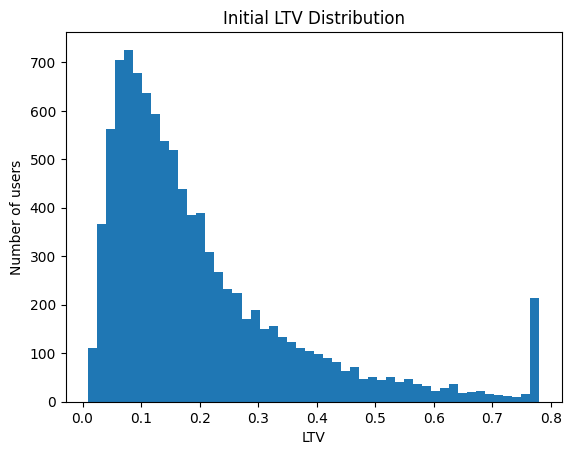

In [5]:
# --- Aggregate stats ---
total_collateral = sum(u.supplied_usd for u in users.values())
total_debt = sum(u.borrowed_usd for u in users.values())
average_ltv = np.mean([u.ltv for u in users.values()])

print(f"Total collateral: {total_collateral:.2f} USD")
print(f"Total debt: {total_debt:.2f} USD")
print(f"Average LTV: {average_ltv:.4f}")


# --- Quick plot of all users' initial LTVs ---
plt.hist([u.ltv for u in users.values()], bins=50)
plt.xlabel("LTV")
plt.ylabel("Number of users")
plt.title("Initial LTV Distribution")
plt.show()